In [1]:
## data source
## http://insideairbnb.com/get-the-data.html

In [2]:
import os
os.getcwd()

'/Users/taeholee/Downloads'

In [3]:
# import packages (data)

import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit, ols, glm

In [4]:
# import packages (visualization)

import seaborn as sns # heatmap
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [5]:
#import packages (text cleaning)

import nltk
import re
from nltk.stem import WordNetLemmatizer
import string

In [6]:
# Raw data (New York September 08 / 2021)

df = pd.read_csv("listings_NY.csv")
df.shape

(36923, 74)

In [7]:
# To get all the column names

my_list = list(df)
#my_list

# Exploratory Visuals

## Descriptive Statistics

In [8]:
#create copy of dataframe for exploratory visuals
df_explore = df.copy(deep=True)

#convert response rate and price into floats
df_explore['host_response_rate'] = df_explore['host_response_rate'].str.replace('%', '')
df_explore['host_response_rate'] = df_explore['host_response_rate'].astype(float)
df_explore['host_response_rate'] = df_explore['host_response_rate']/100

df_explore['price'] = df_explore['price'].str.replace('$', '')
df_explore['price'] = df_explore['price'].str.replace(',','')
df_explore['price'] = df_explore['price'].astype(float)

#run descriptive statistics
round(df_explore.describe(), 3)

<ipython-input-8-b5dcb9587bdd>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_explore['price'] = df_explore['price'].str.replace('$', '')


,id,scrape_id,host_id,host_response_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.692300e+04,3.692300e+04,3.692300e+04,21180.000,36812.000,36812.000,36923.000,36923.000,36923.000,0.0,...,26991.000,27002.000,26987.000,26987.000,0.0,36923.000,36923.000,36923.000,36923.000,27627.000
mean,2.779015e+07,2.021090e+13,1.074324e+08,0.868,32.769,32.769,40.729,-73.950,2.798,NaN,...,4.818,4.814,4.754,4.651,NaN,13.591,6.785,6.677,0.052,1.452
std,1.660802e+07,4.090000e+00,1.233825e+08,0.269,213.665,213.665,0.056,0.050,1.860,NaN,...,0.438,0.457,0.415,0.514,NaN,45.119,31.266,29.159,0.460,4.048
min,2.595000e+03,2.021090e+13,2.438000e+03,0.000,0.000,0.000,40.509,-74.241,0.000,NaN,...,0.000,0.000,0.000,0.000,NaN,1.000,0.000,0.000,0.000,0.010
25%,1.259052e+07,2.021090e+13,1.067204e+07,0.900,1.000,1.000,40.689,-73.983,2.000,NaN,...,4.820,4.820,4.670,4.560,NaN,1.000,0.000,0.000,0.000,0.110
50%,2.858319e+07,2.021090e+13,4.693810e+07,1.000,1.000,1.000,40.726,-73.955,2.000,NaN,...,4.960,4.980,4.880,4.790,NaN,1.000,1.000,0.000,0.000,0.440
75%,4.346777e+07,2.021090e+13,1.824302e+08,1.000,3.000,3.000,40.763,-73.931,4.000,NaN,...,5.000,5.000,5.000,5.000,NaN,3.000,1.000,1.000,0.000,1.510
max,5.200698e+07,2.021090e+13,4.209650e+08,1.000,5069.000,5069.000,40.914,-73.705,16.000,NaN,...,5.000,5.000,5.000,5.000,NaN,307.000,297.000,251.000,10.000,163.190


## Word Clouds / Text Analysis

In [9]:
# select columns for text cleaning. we want to look at the description, neighborhood overview, and amenities fields

df_text = df[["id","price","description","neighborhood_overview",
                "amenities","review_scores_rating"]]
df_text.shape
df_text.head()

,id,price,description,neighborhood_overview,amenities,review_scores_rating
0,2595,$150.00,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,"[""Free street parking"", ""Heating"", ""TV"", ""Dedi...",4.70
1,3831,$76.00,"Enjoy 500 s.f. top floor in 1899 brownstone, w...",Just the right mix of urban center and local n...,"[""Dedicated workspace"", ""Iron"", ""Stove"", ""Hair...",4.46
2,5121,$60.00,<b>The space</b><br />HELLO EVERYONE AND THANK...,NaN,"[""Kitchen"", ""Long term stays allowed"", ""Air co...",4.52
3,5136,$275.00,We welcome you to stay in our lovely 2 br dupl...,NaN,"[""Dryer"", ""BBQ grill"", ""Kitchen"", ""Long term s...",5.00
4,5178,$68.00,Please don’t expect the luxury here just a bas...,"Theater district, many restaurants around here.","[""Hot water"", ""Bed linens"", ""Extra pillows and...",4.21


In [10]:
# create dataframe copy
df_textclean = df_text.copy(deep=True)

# delete $, ","
df_textclean['price'] = df_textclean['price'].str.replace('$', '')
df_textclean['price'] = df_textclean['price'].str.replace(',','')

# convert price to float
df_textclean['price'] = df_textclean['price'].astype(float)

<ipython-input-10-c2e8721dba8d>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_textclean['price'] = df_textclean['price'].str.replace('$', '')


In [11]:
#make sure text fields are strings
df_textclean['description'] = df_text['description'].astype(str)
df_textclean['neighborhood_overview'] = df_text['neighborhood_overview'].astype(str)
df_textclean['amenities'] = df_text['amenities'].astype(str)

In [12]:
#we want to do text analysis on the top-priced airbnb's
#descriptive statistics
df_textclean.price.mode()
df_textclean.describe()
#price stats - min: $0, mean: $169, 25%: $70, 50% (median): $110, 75%: $184, max: $10,000, mode: $150

#create dataframe with top 25% priced airbnb's (> $184)
df_highprice = df_textclean[df_textclean.price > 184]

In [13]:
#convert description column for high priced airbnb's to a string
describe = str(list(df_highprice.description))
describe_lower = describe.lower()
#replace <br /> characters with spaces
describe2 = describe_lower.replace('<br />', '')
describe3 = describe2.replace('<b>', '')
describe4 = describe3.replace('</b>', '')

In [14]:
#split words by white space and punctuation
from nltk.tokenize import word_tokenize
nltk.download('punkt')
tokens_descr = word_tokenize(describe4)
print(tokens_descr[:50]) #print first 50 words to check

#remove standalone punctuation
justwords_descr = [word for word in tokens_descr if word.isalpha()]
print(justwords_descr[:50])

[nltk_data] Downloading package punkt to /Users/taeholee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['[', "'we", 'welcome', 'you', 'to', 'stay', 'in', 'our', 'lovely', '2', 'br', 'duplex', 'in', 'south', 'slope', ',', 'brooklyn', '.', 'our', 'home', 'is', 'a', 'truly', 'spacious', 'respite', 'from', 'the', 'busy', 'city-', 'close', 'to', 'subways', ',', 'restaurants', ',', 'cafes', 'and', 'parks', '.', 'enjoy', 'a', 'gourmet', 'kitchen', ',', 'patio', ',', 'grill', ',', 'backyard', '!']
['welcome', 'you', 'to', 'stay', 'in', 'our', 'lovely', 'br', 'duplex', 'in', 'south', 'slope', 'brooklyn', 'our', 'home', 'is', 'a', 'truly', 'spacious', 'respite', 'from', 'the', 'busy', 'close', 'to', 'subways', 'restaurants', 'cafes', 'and', 'parks', 'enjoy', 'a', 'gourmet', 'kitchen', 'patio', 'grill', 'backyard', 'we', 'are', 'open', 'to', 'a', 'longer', 'term', 'rental', 'please', 'contact', 'me', 'for', 'your']


In [ ]:
#remove stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_descr = [w for w in justwords_descr if not w in stop_words]
print(stop_descr[:50])

#convert list to string
description_clean = ''
for i in stop_descr:
    description_clean += i + " "
description_clean

In [16]:
#import wordcloud generators
!pip install wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

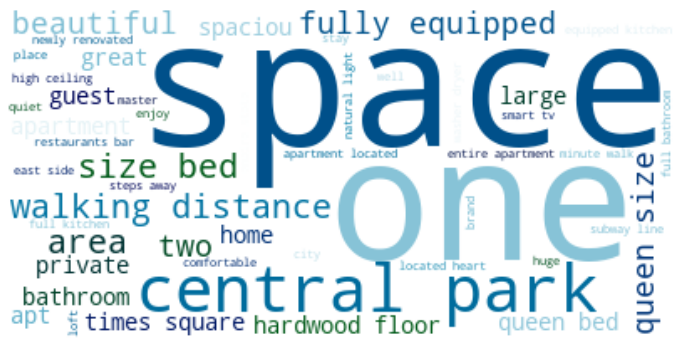

In [17]:
#remove irrelevant words from wordcloud
stopwords_wc = set(STOPWORDS)
stopwords_wc.update(["new", "york", "nyc", "room", "bedroom", "living"])

#make a wordcloud showing the most common words in the descriptions for high priced (top 25%) listings
wordcloud_sq = WordCloud(stopwords=stopwords_wc, max_words = 50, min_font_size = 7, colormap='ocean', background_color="white").generate(description_clean)
plt.figure(figsize=[12,15])
plt.imshow(wordcloud_sq, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
#repeat previous steps for neighborhood overview variable. convert neighborhood overview column for high priced airbnb's to a string
neighborhood = str(list(df_highprice.neighborhood_overview))
neighborhood_lower = neighborhood.lower()
neighborhood_lower
#replace nan and <br> characters with spaces
neighborhood2 = neighborhood_lower.replace('nan', '')
neighborhood3 = neighborhood2.replace('<br />', '')

In [19]:
#split by white space and punctuation
tokens_neighbor = word_tokenize(neighborhood3)
print(tokens_neighbor[:50])

#remove standalone punctuation
justwords_neighbor = [word for word in tokens_neighbor if word.isalpha()]
print(justwords_neighbor[:50])

#remove stopwords
stop_words = set(stopwords.words('english'))
stop_neighbor = [w for w in justwords_neighbor if not w in stop_words]
print(stop_neighbor[:50])

['[', '``', ',', '``', 'residential', ',', 'village-like', 'atmosphere', '.', 'lots', 'of', 'restaurants', '.', 'they', 'are', 'unfortunately', 'limited', 'to', 'outdoors', 'and', 'partial', 'indoors', 'during', 'lockdown', '.', 'many', 'grocery', 'stores', '(', 'wegmans', ',', 'trader', 'joes', ',', 'whole', 'foods', ')', '.', 'half', 'block', 'to', 'wonderful', 'fort', 'greene', 'park', ',', 'and', 'saturday', 'farmer', "'s"]
['residential', 'atmosphere', 'lots', 'of', 'restaurants', 'they', 'are', 'unfortunately', 'limited', 'to', 'outdoors', 'and', 'partial', 'indoors', 'during', 'lockdown', 'many', 'grocery', 'stores', 'wegmans', 'trader', 'joes', 'whole', 'foods', 'half', 'block', 'to', 'wonderful', 'fort', 'greene', 'park', 'and', 'saturday', 'farmer', 'market', 'i', 'like', 'the', 'cinnamon', 'donuts', 'and', 'artisanal', 'bread', 'we', 'lived', 'here', 'for', 'over', 'years', 'and']
['residential', 'atmosphere', 'lots', 'restaurants', 'unfortunately', 'limited', 'outdoors', 'p

In [20]:
#convert neighborhood overview list to string
neighborhood_clean = ''
for i in stop_neighbor:
    neighborhood_clean += i + " "

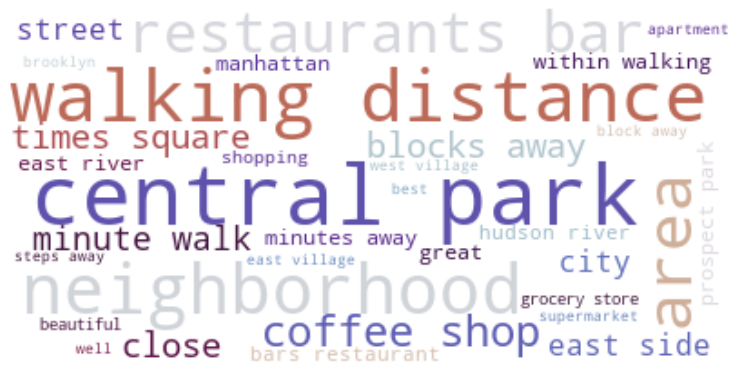

In [21]:
#remove irrelevant words from wordcloud
stopwords_wc = set(STOPWORDS)
stopwords_wc.update(["new", "york", "nyc"])

#make a wordcloud showing the most common words in the neighborhood overview section for high priced (top 25%) listings
wordcloud2_sq = WordCloud(stopwords=stopwords_wc, max_words=50, min_font_size = 7, colormap="twilight_shifted", background_color="white").generate(neighborhood_clean)
plt.figure(figsize=[13,15])
plt.imshow(wordcloud2_sq, interpolation='bilinear')
plt.axis("off")
plt.show()

# Regression Model Cleaning

In [22]:
# split df by location

bronx  = df[df.neighbourhood_group_cleansed == "Bronx"]
brook  = df[df.neighbourhood_group_cleansed == "Brooklyn"]
man    = df[df.neighbourhood_group_cleansed == "Manhattan"]
queens = df[df.neighbourhood_group_cleansed == "Queens"]
si     = df[df.neighbourhood_group_cleansed == "Staten Island"]

In [23]:
# select variables

variables = ["price",
             
             "room_type",
             "neighbourhood_group_cleansed",
             
             "beds",           
             "bedrooms",
             "accommodates",
             
             "instant_bookable",
             "host_identity_verified",
             'host_is_superhost',    
             'host_response_rate',
             'host_acceptance_rate',
             'calculated_host_listings_count', 
            
             'review_scores_rating',
             'review_scores_accuracy',
             'review_scores_cleanliness',
             'review_scores_checkin',
             'review_scores_communication',
             'review_scores_location',
             'review_scores_value',
             
             'availability_30',
             'availability_60',
             'availability_90',
             'availability_365',
             
             'minimum_nights',
             'maximum_nights',

             'number_of_reviews_ltm'
            ]

In [24]:
# select columns

df_select = df[variables]
bronx_select = bronx[variables]
brook_select = brook[variables]
man_select = man[variables]
queens_select = queens[variables]
si_select = si[variables]
df_select.shape

(36923, 26)

In [25]:
# delete NaN Values

df_clean = df_select.dropna()
bronx_clean = bronx_select.dropna()
brook_clean = brook_select.dropna()
man_clean = man_select.dropna()
queens_clean = queens_select.dropna()
si_clean = si_select.dropna()
df_clean.shape

(13558, 26)

In [26]:
# make neighbourhood_group_cleansed to dummy variable

dummy = pd.get_dummies(df_clean.neighbourhood_group_cleansed)

# add dummy variables to df_clean

df_new = pd.concat([df_clean, dummy], axis=1)

# delete neighbourhood_group_cleansed

df_new.drop(columns=["neighbourhood_group_cleansed"], inplace=True)

In [27]:
# make room_type to dummy variable

dummy2 = pd.get_dummies(df_new.room_type)
dummy2_bronx = pd.get_dummies(bronx_clean.room_type)
dummy2_brook = pd.get_dummies(brook_clean.room_type)
dummy2_man = pd.get_dummies(man_clean.room_type)
dummy2_queens = pd.get_dummies(queens_clean.room_type)
dummy2_si= pd.get_dummies(si_clean.room_type)

# add dummy variables to df_clean

df_new = pd.concat([df_new, dummy2], axis=1)
bronx_new = pd.concat([bronx_clean, dummy2_bronx], axis=1)
brook_new = pd.concat([brook_clean, dummy2_brook], axis=1)
man_new = pd.concat([man_clean, dummy2_man], axis=1)
queens_new = pd.concat([queens_clean, dummy2_queens], axis=1)
si_new = pd.concat([si_clean, dummy2_si], axis=1)

# delete room_type

df_new.drop(columns=["room_type"], inplace=True)
bronx_new.drop(columns=["room_type"], inplace=True)
brook_new.drop(columns=["room_type"], inplace=True)
man_new.drop(columns=["room_type"], inplace=True)
queens_new.drop(columns=["room_type"], inplace=True)
si_new.drop(columns=["room_type"], inplace=True)

In [28]:
# replace t/f value to 1/0

clean_dataset = [df_new, bronx_new, brook_new, man_new, queens_new, si_new]

for i in clean_dataset:
    i['instant_bookable'] = i['instant_bookable'].replace(('t','f'),("1","0"))
    i['instant_bookable'] = i['instant_bookable'].astype(float)
    i['host_identity_verified'] = i['host_identity_verified'].replace(('t','f'),("1","0"))
    i['host_identity_verified'] = i['host_identity_verified'].astype(float)
    i['host_is_superhost'] = i['host_is_superhost'].replace(('t','f'),("1","0"))
    i['host_is_superhost'] = i['host_is_superhost'].astype(float)

In [29]:
# replace unit8 to numeric

df_new['Bronx'] = df_new['Bronx'].astype(float)
df_new['Brooklyn'] = df_new['Brooklyn'].astype(float)
df_new['Manhattan'] = df_new['Manhattan'].astype(float)
df_new['Queens'] = df_new['Queens'].astype(float)
df_new['Staten Island'] = df_new['Staten Island'].astype(float)
df_new['Entire home/apt'] = df_new['Entire home/apt'].astype(float)
df_new['Hotel room'] = df_new['Hotel room'].astype(float)
df_new['Private room'] = df_new['Private room'].astype(float)
df_new['Shared room'] = df_new['Shared room'].astype(float)

In [30]:
# convert host response rate, host acceptance rate to float

for i in clean_dataset:
    i['host_response_rate'] = i['host_response_rate'].str.replace('%', '')
    i['host_response_rate'] = i['host_response_rate'].astype(float)
    i['host_acceptance_rate'] = i['host_acceptance_rate'].str.replace('%', '')
    i['host_acceptance_rate'] = i['host_acceptance_rate'].astype(float)

In [31]:
# convert price values to float

for i in clean_dataset:
    i['price'] = i['price'].str.replace('$', '')
    i['price'] = i['price'].str.replace(',','')
    i['price'] = i['price'].astype(float)

<ipython-input-31-f86dd8c8ad7f>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  i['price'] = i['price'].str.replace('$', '')


In [32]:
# delete outlier
# +- 3 sgma : sigma is too big(becasue of right skewed), so do not use it
# use 1.5IQR instead

lst_upper=[]
lst_lower=[]
for i in clean_dataset:
    q75, q25 = np.percentile(i.price, [75 ,25])
    iqr = q75 - q25
    upper = q75+1.5*iqr
    lower = q25-1.5*iqr
    lst_upper.append(upper)
    lst_lower.append(lower)

df_new = df_new[df_new.price < lst_upper[0]]
bronx_new = bronx_new[bronx_new.price < lst_upper[1]]
brook_new = brook_new[brook_new.price < lst_upper[2]]
man_new = man_new[man_new.price < lst_upper[3]]
queens_new = queens_new[queens_new.price < lst_upper[4]]
si_new = si_new[si_new.price < lst_upper[5]]

In [33]:
# last check the number of observations

df_new.shape

(12593, 33)

In [34]:
# Create correlation matrix

corr_matrix = df_new.corr().abs()

# Select upper triangle of correlation matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.7

to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

<ipython-input-34-bd4866fc0ba7>:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


<AxesSubplot:>

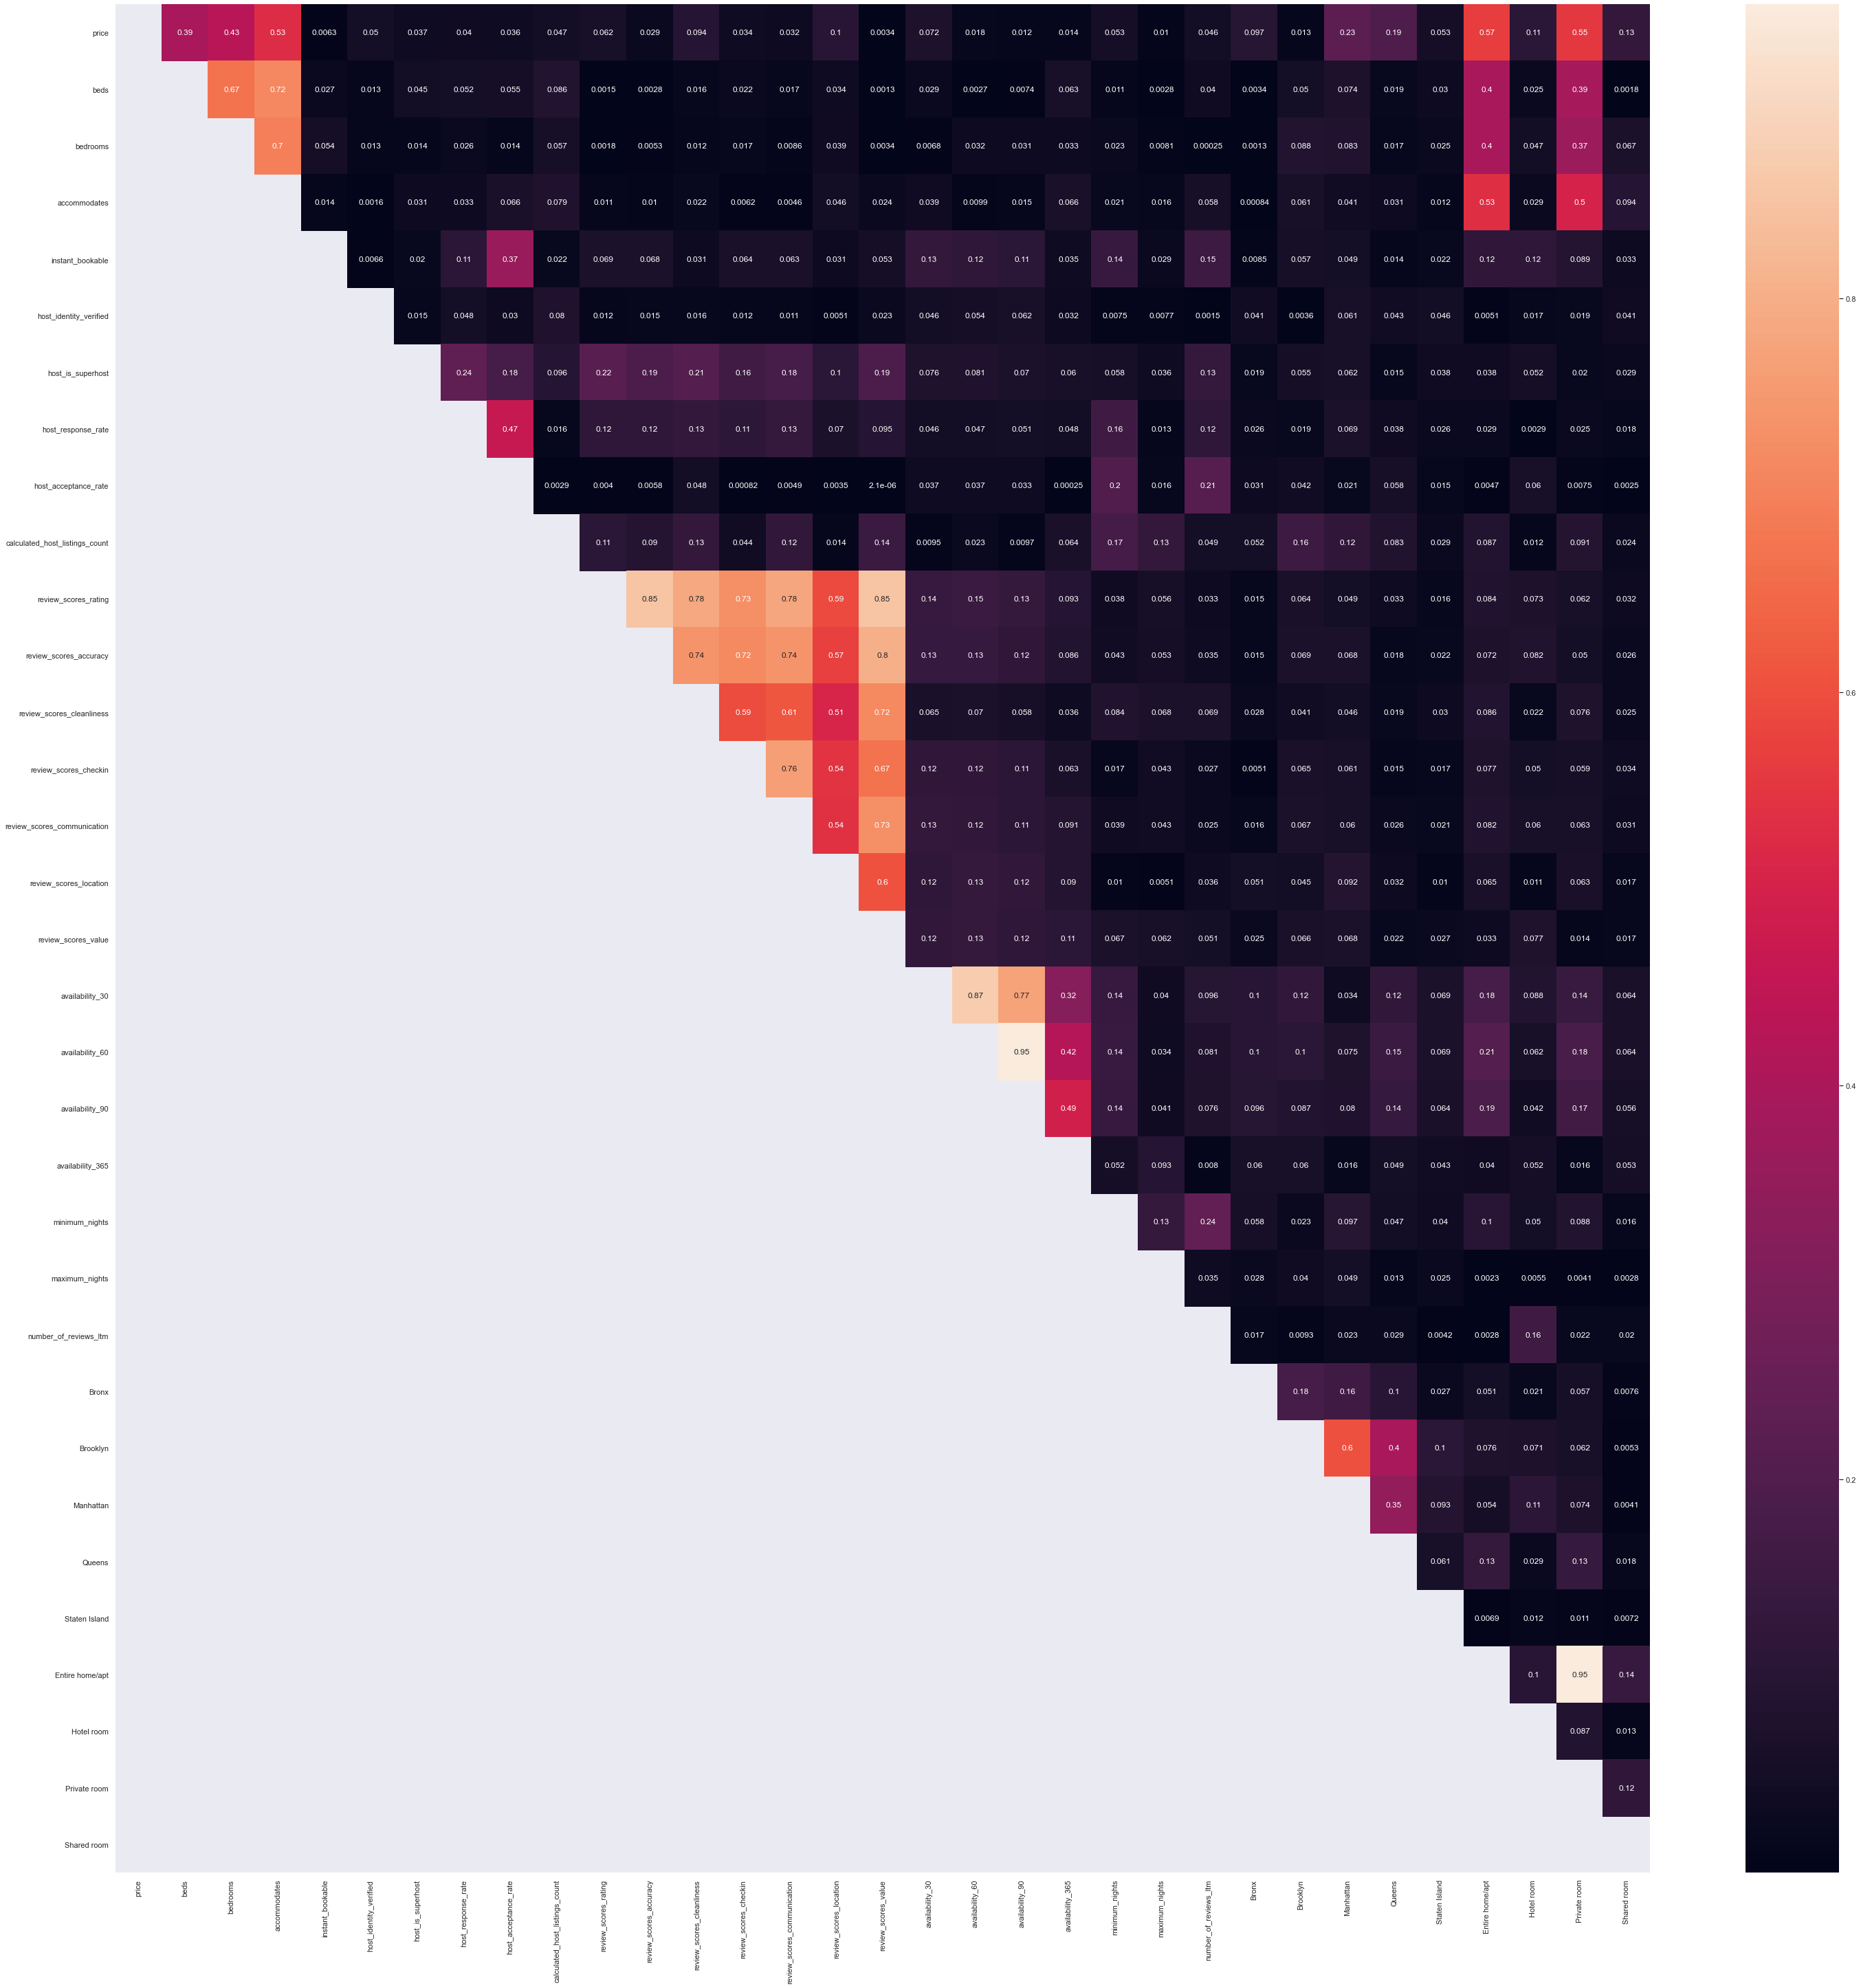

In [35]:
# draw heatmap (all)

sns.set(rc = {'figure.figsize': (50,50)})
sns.heatmap(upper, annot=True)

In [36]:
# check collinearity

df_guest = df_new[['accommodates','beds','bedrooms']]
df_scores = df_new[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin','review_scores_communication','review_scores_location',
                    'review_scores_value',]]
df_avilability = df_new[['availability_30','availability_60','availability_90','availability_365']]
df_super = df_new[["host_is_superhost","host_response_rate",'review_scores_rating']]

corr_guest = df_guest.corr()
corr_scores = df_scores.corr()
corr_availability = df_avilability.corr()
corr_super = df_super.corr()

<AxesSubplot:>

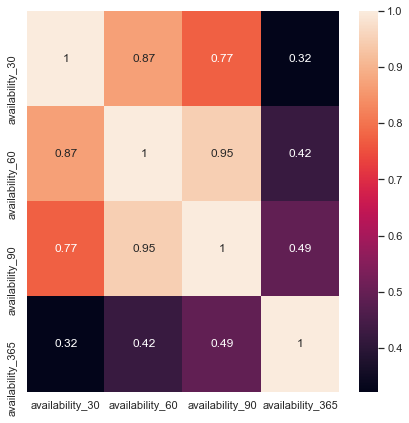

In [37]:
# draw heatmap (partial)

sns.set(rc = {'figure.figsize': (7,7)})
sns.heatmap(corr_availability, annot=True)

In [38]:
# check correlation between price

corr = df_new.corr()
corr_abs = abs(df_new.corr()) # absolute value
corr_abs.price.sort_values(ascending=False)

price                             1.000000
Entire home/apt                   0.565835
Private room                      0.554733
accommodates                      0.529722
bedrooms                          0.433575
beds                              0.393924
Manhattan                         0.227802
Queens                            0.194899
Shared room                       0.127460
Hotel room                        0.106101
review_scores_location            0.100437
Bronx                             0.096955
review_scores_cleanliness         0.094368
availability_30                   0.072275
review_scores_rating              0.061638
Staten Island                     0.053121
minimum_nights                    0.053022
host_identity_verified            0.050477
calculated_host_listings_count    0.046719
number_of_reviews_ltm             0.046001
host_response_rate                0.040329
host_is_superhost                 0.036924
host_acceptance_rate              0.036164
review_scor

# Regression Modeling

In [39]:
# spllit dataset to training and test (ordinal)

all_70 = df_new.iloc[:int(len(df_new)*(70/100))]
all_30 = df_new.drop(all_70.index)

bronx_70 = bronx_new.iloc[:int(len(bronx_new)*(70/100))]
bronx_30 = bronx_new.drop(bronx_70.index)

brook_70 = brook_new.iloc[:int(len(brook_new)*(70/100))]
brook_30 = brook_new.drop(brook_70.index)

man_70 = man_new.iloc[:int(len(man_new)*(70/100))]
man_30 = man_new.drop(man_70.index)

queens_70 = queens_new.iloc[:int(len(queens_new)*(70/100))]
queens_30 = queens_new.drop(queens_70.index)

si_70 = si_new.iloc[:int(len(si_new)*(70/100))]
si_30 = si_new.drop(si_70.index)

In [40]:
# Run regression

Y = all_70['price']
X = all_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',

    # default is Bronx
    'Brooklyn',
    'Manhattan',
    'Queens',
    'Staten Island',
    
    'accommodates', 
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'calculated_host_listings_count',  
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'availability_30',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     409.5
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:05:44   Log-Likelihood:                -47364.
No. Observations:                8815   AIC:                         9.478e+04
Df Residuals:                    8790   BIC:                         9.495e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [41]:
# Run regression after removing

Y = all_70['price']
X = all_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',

    # default is Bronx
    'Brooklyn',
    'Manhattan',
    'Queens',
    'Staten Island',
    
    'accommodates',
#    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
#    'calculated_host_listings_count', 
#    'review_scores_accuracy',
    'review_scores_cleanliness',
#    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'availability_30',
    'minimum_nights',
#    'maximum_nights',
    'number_of_reviews_ltm'
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     516.9
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:05:44   Log-Likelihood:                -47367.
No. Observations:                8815   AIC:                         9.477e+04
Df Residuals:                    8795   BIC:                         9.491e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [42]:
# Run regression with test set

Y = all_30['price']
X = all_30[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',

    # default is Bronx
    'Brooklyn',
    'Manhattan',
    'Queens',
    'Staten Island',
    
    'accommodates',
#    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
#    'calculated_host_listings_count', 
#    'review_scores_accuracy',
    'review_scores_cleanliness',
#    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'availability_30',
    'minimum_nights',
#    'maximum_nights',
    'number_of_reviews_ltm'
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     205.9
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:05:44   Log-Likelihood:                -20571.
No. Observations:                3778   AIC:                         4.118e+04
Df Residuals:                    3759   BIC:                         4.130e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [43]:
# Bronx training before removing

Y = bronx_70['price']
X = bronx_70[[
    # default is entire home/apt
#    'Hotel room',
    'Private room',
    'Shared room',
    
    'accommodates',
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'calculated_host_listings_count', 
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'availability_30',  
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm'
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     27.82
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.30e-57
Time:                        14:05:44   Log-Likelihood:                -1666.6
No. Observations:                 357   AIC:                             3373.
Df Residuals:                     337   BIC:                             3451.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [44]:
# Bronx training after removing

# Bronx

Y = bronx_70['price']
X = bronx_70[[
    # default is entire home/apt
#    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'host_is_superhost',    
    'review_scores_accuracy',
    'review_scores_cleanliness',             
    'availability_30'
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     75.59
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           4.18e-66
Time:                        14:05:44   Log-Likelihood:                -1670.2
No. Observations:                 357   AIC:                             3356.
Df Residuals:                     349   BIC:                             3387.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [45]:
# Bronx test

# Bronx

Y = bronx_30['price']
X = bronx_30[[
    # default is entire home/apt
#    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'host_is_superhost',    
    'review_scores_accuracy',
    'review_scores_cleanliness',             
    'availability_30'
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     32.15
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.62e-24
Time:                        14:05:44   Log-Likelihood:                -732.21
No. Observations:                 154   AIC:                             1478.
Df Residuals:                     147   BIC:                             1500.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [46]:
# Brooklyn training before removing 

Y = brook_70['price']
X = brook_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    
    'accommodates',
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'calculated_host_listings_count', 
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',             
    'availability_30',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     176.6
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:05:44   Log-Likelihood:                -19072.
No. Observations:                3556   AIC:                         3.819e+04
Df Residuals:                    3535   BIC:                         3.832e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [47]:
# Brooklyn training after removing 

Y = brook_70['price']
X = brook_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'review_scores_cleanliness',
    'review_scores_location',
    'review_scores_value',  
    'availability_30',
    'minimum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     235.5
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:05:44   Log-Likelihood:                -19073.
No. Observations:                3556   AIC:                         3.818e+04
Df Residuals:                    3540   BIC:                         3.828e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [48]:
# Brooklyn test

Y = brook_30['price']
X = brook_30[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'review_scores_cleanliness',
    'review_scores_location',
    'review_scores_value',  
    'availability_30',
    'minimum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     106.3
Date:                Fri, 10 Dec 2021   Prob (F-statistic):          5.31e-213
Time:                        14:05:44   Log-Likelihood:                -8304.2
No. Observations:                1524   AIC:                         1.664e+04
Df Residuals:                    1509   BIC:                         1.672e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [49]:
# manhattan training before removing

Y = man_70['price']
X = man_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    
    'accommodates',
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'calculated_host_listings_count', 
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'availability_30',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     140.3
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:05:44   Log-Likelihood:                -18100.
No. Observations:                3214   AIC:                         3.624e+04
Df Residuals:                    3193   BIC:                         3.637e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [50]:
# manhattan training after removing

Y = man_70['price']
X = man_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'instant_bookable',
    'calculated_host_listings_count', 
    'review_scores_cleanliness',
    'review_scores_location',
    'review_scores_value',
    'availability_30',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     211.9
Date:                Fri, 10 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:05:44   Log-Likelihood:                -18116.
No. Observations:                3214   AIC:                         3.626e+04
Df Residuals:                    3200   BIC:                         3.634e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [51]:
# manhattan test

Y = man_30['price']
X = man_30[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'instant_bookable',
    'calculated_host_listings_count', 
    'review_scores_cleanliness',
    'review_scores_location',
    'review_scores_value',
    'availability_30',
    'minimum_nights', 
    'maximum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     89.14
Date:                Fri, 10 Dec 2021   Prob (F-statistic):          6.32e-162
Time:                        14:05:44   Log-Likelihood:                -7778.8
No. Observations:                1378   AIC:                         1.558e+04
Df Residuals:                    1365   BIC:                         1.565e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [52]:
# queens training before removing

Y = queens_70['price']
X = queens_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    
    'accommodates',
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'calculated_host_listings_count', 
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'availability_30',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm'
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     124.1
Date:                Fri, 10 Dec 2021   Prob (F-statistic):          4.10e-304
Time:                        14:05:44   Log-Likelihood:                -7539.4
No. Observations:                1574   AIC:                         1.512e+04
Df Residuals:                    1553   BIC:                         1.523e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [53]:
# queens training after removing

Y = queens_70['price']
X = queens_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'host_is_superhost',    
    'review_scores_cleanliness',
    'review_scores_location',
    'availability_30',
    'minimum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     248.2
Date:                Fri, 10 Dec 2021   Prob (F-statistic):          4.61e-314
Time:                        14:05:44   Log-Likelihood:                -7542.5
No. Observations:                1574   AIC:                         1.511e+04
Df Residuals:                    1563   BIC:                         1.517e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [54]:
# queens test

Y = queens_30['price']
X = queens_30[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'host_is_superhost',    
    'review_scores_cleanliness',
    'review_scores_location',
    'availability_30',
    'minimum_nights',
    'number_of_reviews_ltm',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     133.5
Date:                Fri, 10 Dec 2021   Prob (F-statistic):          1.27e-142
Time:                        14:05:44   Log-Likelihood:                -3292.1
No. Observations:                 675   AIC:                             6604.
Df Residuals:                     665   BIC:                             6649.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [55]:
# si training before removing

Y = si_70['price']
X = si_70[[
    # default is entire home/apt
#    'Hotel room',
    'Private room',
    'Shared room',
    
    'accommodates',
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'calculated_host_listings_count', 
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'availability_30',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm'
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     12.10
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           2.72e-19
Time:                        14:05:44   Log-Likelihood:                -611.57
No. Observations:                 133   AIC:                             1263.
Df Residuals:                     113   BIC:                             1321.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [56]:
# si training after removing

Y = si_70['price']
X = si_70[[
    # default is entire home/apt
#    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'availability_30',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     48.31
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           1.05e-24
Time:                        14:05:44   Log-Likelihood:                -624.18
No. Observations:                 133   AIC:                             1258.
Df Residuals:                     128   BIC:                             1273.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              71.7614      7.696     

In [57]:
# si test

Y = si_30['price']
X = si_30[[
    # default is entire home/apt
#    'Hotel room',
    'Private room',
    'Shared room',
    'accommodates',
    'availability_30',
]]
X = sm.add_constant(X)
model = sm.OLS(Y,X)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     21.70
Date:                Fri, 10 Dec 2021   Prob (F-statistic):           2.67e-09
Time:                        14:05:44   Log-Likelihood:                -269.35
No. Observations:                  57   AIC:                             546.7
Df Residuals:                      53   BIC:                             554.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              90.3950     11.968     

In [58]:
# remove p-value above 0.05 (forward selection)

def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [59]:
# split dataset to training and test (randomly)

# Creating a dataframe with 70% values of original dataframe
#part_70 = df_new.sample(frac = 0.7)
 
# Creating dataframe with rest of the 30% values
#part_30 = df_new.drop(part_70.index)

In [60]:
# run regression 20 times with random sampling (70%)

res=[]
for i in range(0,20):
    part_70 = df_new.sample(frac = 0.7)
    Y = part_70['price']
    X = part_70[[
    # default is entire home/apt
    'Hotel room',
    'Private room',
    'Shared room',

    # default is Bronx
    'Brooklyn',
    'Manhattan',
    'Queens',
    'Staten Island',
    
    'accommodates', 

    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'calculated_host_listings_count', 
             
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
             
    'availability_30',
             
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm'
]]
    selected = forward_selection(X,Y)
    res.append(selected)

<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)
<ipython-input-58-9faf5d875475>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=remaining_features)


In [61]:
# find duplication for each forward selection variables

dup={
    'Hotel room',
    'Private room',
    'Shared room',
    'Brooklyn',
    'Manhattan',
    'Queens',
    'Staten Island',
    'accommodates', 
    'instant_bookable',
    'host_identity_verified',
    'host_is_superhost',    
    'host_response_rate',
    'host_acceptance_rate',
    'calculated_host_listings_count', 
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',  
    'availability_30',
    'minimum_nights',
    'maximum_nights',
    'number_of_reviews_ltm'}
for i in range(0,20):
    dup = dup & set(res[i])
dup

{'Brooklyn',
 'Hotel room',
 'Manhattan',
 'Private room',
 'Queens',
 'Shared room',
 'accommodates',
 'availability_30',
 'host_identity_verified',
 'minimum_nights',
 'number_of_reviews_ltm',
 'review_scores_cleanliness',
 'review_scores_location',
 'review_scores_value'}